In [607]:
import pandas as pd
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, callbacks
from tensorflow.keras.utils import Sequence, load_img, img_to_array
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GaussianNoise
import os
import matplotlib.pyplot as plt

import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

from time import sleep
from tqdm.notebook import tqdm
from IPython.display import clear_output

# Draw Landmarks on Image
Can be used with images or live feed.

In [368]:
MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

# noinspection PyShadowingNames
def draw_landmarks(current_frame, landmarker_result):
  hand_landmarks_list = landmarker_result.hand_landmarks
  handedness_list = landmarker_result.handedness
  annotated_image = np.copy(current_frame)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_protocol = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_protocol.landmark.extend([
    # Normalize the coordinates
      landmark_pb2.NormalizedLandmark(
          x=landmark.x, 
          y=landmark.y, 
          z=landmark.z) for landmark in hand_landmarks])
    
    # Draw the landmarks
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_protocol,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN
    
    # Draw bounding box
    xmin, xmax = int(min(x_coordinates) * width), int(max(x_coordinates) * width)
    ymin, ymax = int(min(y_coordinates) * height), int(max(y_coordinates) * height)
    boxW, boxH = xmax - xmin, ymax - ymin
    cv2.rectangle(annotated_image, 
                 pt1=(xmin - 20, ymin - 20), pt2=(xmin + boxW + 20, ymin + boxH + 20), 
                 color=(0, 0, 255), thickness=2)
    
    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}", (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX, FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)
               
  return annotated_image

model_path = 'hand_landmarker.task'
BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

# Create a hand landmarker instance with the image mode:
options_image = HandLandmarkerOptions(base_options=BaseOptions(model_asset_path=model_path), running_mode=VisionRunningMode.IMAGE, num_hands=1)
HandLandmarker_image = vision.HandLandmarker.create_from_options(options)

options_live = HandLandmarkerOptions(base_options=BaseOptions(model_asset_path=model_path), running_mode=VisionRunningMode.LIVE_STREAM, num_hands=1)
HandLandmarker_live = vision.HandLandmarker.create_from_options(options)

In [369]:
def ExplodeFrameData(handlandmarks):
    df_handlandmarks = pd.DataFrame([handlandmarks])
    joined = pd.DataFrame()
    for col in ['handedness','hand_landmarks']:        
        df = pd.json_normalize(df_handlandmarks[col])
        df = pd.json_normalize(df[0])
       # df = pd.concat([df.drop(columns=[0]), df], axis=1)
        df_list = df[0].tolist()
        df_norm = pd.json_normalize(df_list)
        joined = pd.concat([joined, df_norm], axis=1)
        
    joined = joined.reset_index(drop=True).drop('index',axis=1)
    joined = joined.drop(columns=['display_name', 'visibility', 'presence'])
    joined = pd.get_dummies(joined, columns=['category_name'], dtype=int)
    joined = joined.rename(columns={'category_name_Left':'left', 'category_name_Right':'right'}).dropna()
    print(joined)
    return joined

In [4]:

capture = cv2.VideoCapture(0) 
if not capture.isOpened():
    print("Cannot open camera")
    exit()
    
while True:
    ret, current_frame = capture.read()
    if not ret: 
        print("Can't receive frame (stream end?). Exiting ...") 
        break
        
    # Get Current Frame
    current_frame = cv2.flip(current_frame, 1)
    
    # Process Image Frame
    mp_frame = mp.Image(image_format=mp.ImageFormat.SRGB, data=current_frame)
    
    # Detect Hand Landmarks
    HandLandmarkerResult = HandLandmarker_live.detect(mp_frame)
    
    annotated_frame = draw_landmarks(mp_frame.numpy_view(), HandLandmarkerResult)
    cv2.imshow('annotated_frame', cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
    
    # Pre-Process Hand Landmark Image Frame
    if HandLandmarkerResult.hand_landmarks:
        cleaned_frame = ExplodeFrameData(HandLandmarkerResult)
    
    if cv2.waitKey(1) == ord('q'): 
        break
        
capture.release()
cv2.destroyAllWindows()

2024-08-27 05:06:33.624 python[14091:628822] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


# Custom Image Generator
To only take a number of samples to include in the dataset.

In [450]:
class CustomPreprocessImage(Sequence):
    def __init__(self, directory, classes, images_per_class, split, target_size=(150, 150), 
                 batch_size=32, remove_images=dict()):
        self.directory = directory
        self.classes = classes
        self.images_per_class = images_per_class
        self.target_size = target_size
        self.batch_size = batch_size
        self.filepaths = []
        self.labels = []
        self.handlandmarks = []
        self.split = split
        self.selected_images = dict()
        self.image_names = []
        self.remove_images = remove_images
        self._initialize()
        
    def _initialize(self):
        for class_name in self.classes:
            class_dir = os.path.join(self.directory, class_name)
            class_image_files = os.listdir(class_dir)
            class_index = self.classes.index(class_name)
            bar = tqdm(total = self.images_per_class)
            
            if self.images_per_class == 0:
                return
            # Set Images per Class from Float (% Of Classes).
            if 0.0 < self.images_per_class and self.images_per_class <= 1.0:
                self.images_per_class = int(self.images_per_class * len(class_image_files))
            self.images_per_class = len(class_image_files) if self.images_per_class > len(class_image_files) else self.images_per_class 
            
            print("... {}: now processessing class '{}' [{}/{}]".format(self.split, class_name, class_index, len(classes)))
            # Generate random images
            self.selected_images[class_index] = dict()
            i = 0
            n_imgs_required = self.images_per_class
            while i < n_imgs_required:
                j = random.randint(i, len(class_image_files) - 1)
                class_image_files[i], class_image_files[j] = class_image_files[j], class_image_files[i]
                
                # If already exists in training data set, find another the image file
                if len(self.remove_images) > 0 and self.remove_images[class_index].get(class_image_files[i]):
                    n_imgs_required += 1
                else:
                    self.selected_images[class_index][class_image_files[i]] = True
                i += 1
                
            # Iterate each image in Class, perform Hand Landmark Detection, append results.
            for img_name in self.selected_images[class_index]:            
                img_path = os.path.join(class_dir, img_name)
                
                image = mp.Image.create_from_file(img_path)
                detection_result = HandLandmarker_image.detect(image)
                
                self.image_names.append(img_name)
                self.filepaths.append(img_path)
                self.handlandmarks.append(detection_result)
                self.labels.append(class_index)
                
                sleep(0.1)
                bar.update(1)
            clear_output(wait=True)
        bar.close() 
        self.filepaths = np.array(self.filepaths)
        self.labels = np.array(self.labels)
        print("Samples in {} Set = {}".format(self.split, len(self.labels)))
    
    def __len__(self):
        return int(np.ceil(len(self.filepaths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filepaths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for img_path in batch_x:
            img = load_img(img_path, target_size=self.target_size)
            img_array = img_to_array(img)
            images.append(img_array)

        images = np.array(images).astype('float32') / 255.0
        labels = np.array(batch_y)

        return images, labels
    
     
def CustomImageTrainTestSplit(directory, classes, train_per_class, validation_per_class=0, target_size=(150, 150), batch_size=32):
    train = CustomPreprocessImage(directory, classes, images_per_class = train_per_class, 
                                  target_size=target_size, batch_size=batch_size, split='train')
    validation = CustomPreprocessImage(directory, classes, images_per_class = validation_per_class, 
                                 target_size=target_size, batch_size=batch_size, split='validation', remove_images = train.selected_images)
    return train, validation

Exception ignored in: <function ProgressBarMixinBase.__del__ at 0x7fa1cef08160>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/site-packages/progressbar/bar.py", line 48, in __del__
    if not self._finished:  # pragma: no cover
AttributeError: 'ProgressBar' object has no attribute '_finished'
Exception ignored in: <function ProgressBarMixinBase.__del__ at 0x7fa1cef08160>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/site-packages/progressbar/bar.py", line 48, in __del__
    if not self._finished:  # pragma: no cover
AttributeError: 'ProgressBar' object has no attribute '_finished'
Exception ignored in: <function ProgressBarMixinBase.__del__ at 0x7fa1cef08160>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.10/site-packages/progressbar/bar.py", line 48, in __del__
    if not self._finished:  # pragma: no cover
AttributeError: 'ProgressBar' object has no attribute '_finished'
Exception ignored in: <function Progr

In [451]:
# Set up data directories
train_dir = '/Users/neko/Library/CloudStorage/GoogleDrive-nclosfu@gmail.com/My Drive/CODING-PROJECTS/Python/Python-ASL-Image-to-Alphabet/img/asl_alphabet_train' 
test_dir = '/Users/neko/Library/CloudStorage/GoogleDrive-nclosfu@gmail.com/My Drive/CODING-PROJECTS/Python/Python-ASL-Image-to-Alphabet/img/asl_alphabet_test/test/' 

# Set up Training Dataset
- Get only subset of data per class
## Pre-process Data
- Define some parameters
- Get random sample and img data
- Generate handlandmark data
- Store results

In [452]:
train_per_classB = 5
classesB = os.listdir(train_dir)
classesB.pop(0)
num_classesB = len(classes)
validation_per_classB = 5
target_sizeB = (150,150)
batch_sizeB = 32

trainB, testB = CustomImageTrainTestSplit(train_dir, classesB, train_per_class=train_per_classB, validation_per_class=validation_per_classB, target_size=target_sizeB, batch_size=batch_sizeB)

  0%|          | 0/5 [00:00<?, ?it/s]

... train: now processessing class 'T' [6/29]


KeyboardInterrupt: 

In [426]:
trainB.handlandmarks

[]

In [96]:
set(trainB.image_names) & set(testB.image_names)

set()

In [359]:
train_per_class = 300
classes = os.listdir(train_dir)
classes.pop(0)
num_classes = len(classes)
validation_per_class = 200
target_size = (150,150)
batch_size = 32

train, test = CustomImageTrainTestSplit(train_dir, classes, train_per_class=train_per_class, validation_per_class=validation_per_class, target_size=target_size, batch_size=batch_size)

Samples in train Set = 8700
Samples in validation Set = 5800


In [349]:
print(train.handlandmarks[:10])

[HandLandmarkerResult(handedness=[[Category(index=0, score=0.9339241981506348, display_name='Left', category_name='Left')]], hand_landmarks=[[NormalizedLandmark(x=0.7916381359100342, y=0.9057715535163879, z=4.3904825020035787e-07, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8429147005081177, y=0.8432563543319702, z=-0.04014359042048454, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8621575832366943, y=0.7448129653930664, z=-0.05179156735539436, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8091897368431091, y=0.6705950498580933, z=-0.06410767883062363, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.7447367906570435, y=0.6298298835754395, z=-0.07307327538728714, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8742312788963318, y=0.6342442631721497, z=-0.0032171353232115507, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.8457646369934082, y=0.5119822025299072, z=-0.03550481051206589, visibility=0.0, presence=0.0), NormalizedLandmark(x=0.81964

### Visualize Results

In [453]:
def show_images(num_imgs, train_set, x_axs, y_axs):
    num_imgs = num_imgs
    x_axs = num_imgs//x_axs
    y_axs = y_axs
    fig, ax = plt.subplots(x_axs+1, y_axs+1) 
    x = 0
    y = 0
    for i in range(num_imgs):
        random_img = int(random.randint(0, len(train_set.filepaths)-1))
        image = mp.Image.create_from_file(train_set.filepaths[random_img])
        annotated_image = draw_landmarks(image.numpy_view(), train_set.handlandmarks[random_img])
        ax[x][y].axis('off')
        ax[x][y].set_title(classes[train.labels[random_img]])
        ax[x][y].imshow(annotated_image)
        if y == y_axs:
            y = 0
            x += 1
        else:
            y += 1
    plt.show()

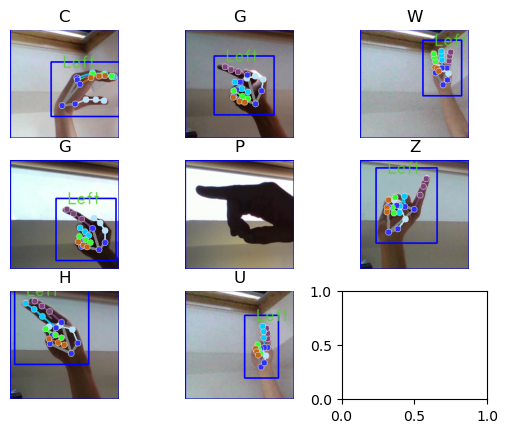

In [454]:
show_images(8, train, 3, 2)

# Pre-Process the Hand Landmark Data

## For each image we have:

### `HandLandmarkerResult`
#### Array of the Left/Right Hand Data
`handedness=[[`
    
    Category(index=float, score=float, display_name=str, category_name=str)]]

To access an image's handedness data and attributes:
`train.handlandmarks[img.idx].handedness[0][0].attribute`

#### Array of Hand Landmark Data:
`hand_landmarks=[[`
        
    NormalizedLandmark(x=float, y=float, z=float, visibility=float, presence=float)

To access an image's hand landmark data coordinates and attributes:
`train.handlandmarks[img.idx].hand_landmarks[0][0].attribute`


## Custom Pre-processing Methods

In [787]:
def ExplodeData(data, pca_components, data_labels=None):
    # Get img paths
    image_names = pd.DataFrame(data.image_names, columns=['img_name'])
    classes = pd.DataFrame(data_labels, columns=['alphabet'])
    
    df_handlandmarks_data = pd.DataFrame(data.handlandmarks)
     
    # Process 'handedness' column
    df_handedness = pd.json_normalize(df_handlandmarks_data['handedness'])
    df_handedness = pd.json_normalize(df_handedness[0])
    df_handedness = pd.concat([df_handedness.drop(columns=[0]), df_handedness], axis=1)
    df_handedness_list = df_handedness[0].tolist()
    df_handedness = pd.json_normalize(df_handedness_list)
    joined_handedness = pd.DataFrame()
    joined_handedness = pd.concat([joined_handedness, df_handedness], axis=1)
        
    # Process 'hand_landmarks' column
    df_hand_landmarks = pd.json_normalize(df_handlandmarks_data['hand_landmarks'])
    df_hand_landmarks = pd.json_normalize(df_hand_landmarks[0])
    df_hand_landmarks_expanded = pd.DataFrame()
    
    for i in range(0, df_hand_landmarks.shape[1]):
        # Extract 'x', 'y', 'z' from the list of dictionaries in each column
        df_hand_landmarks_expanded[f'x{i}'] = df_hand_landmarks.apply(lambda r: r[i]['x'] if r[i] is not None else None, axis=1)
        df_hand_landmarks_expanded[f'y{i}'] = df_hand_landmarks.apply(lambda r: r[i]['y'] if r[i] is not None else None, axis=1)
        df_hand_landmarks_expanded[f'z{i}'] = df_hand_landmarks.apply(lambda r: r[i]['z'] if r[i] is not None else None, axis=1)    
  
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    # Fill in NA Values by Mean
    imputed_df = pd.DataFrame(imputer.fit_transform(df_hand_landmarks_expanded), columns=df_hand_landmarks_expanded.columns)
    scaled_df = scaler.fit_transform(imputed_df)
    
    # Fit PCA
    pca = PCA(n_components = pca_components)
    pca_result = pca.fit_transform(scaled_df)
    pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca.n_components_)])

    # Concat the handedness and hand_landmarks data
    joined_all = pd.concat([joined_handedness, pca_df, classes, image_names], axis=1).dropna()
    joined_all = joined_all.reset_index(drop=True).drop('index',axis=1)
    
    return joined_all, pca_result

def GetFeaturesAndLabels(dataframe):
    # One Hot Enconding Left and Right Values
    dataframe = pd.get_dummies(dataframe, columns=['category_name'], dtype=int)
    dataframe = dataframe.rename(columns={'category_name_Left':'left', 'category_name_Right':'right'})
    
    cleaned_labels = pd.DataFrame(dataframe['alphabet'])
    cleaned_img_paths = pd.DataFrame(dataframe['img_name'])
    cleaned_features = dataframe.drop(columns=['score','alphabet','display_name', 'img_name'])
    
    return cleaned_features, cleaned_labels, cleaned_img_paths

## Pre-process Training and Test Datasets

In [788]:
cleaned_train_features, train_pca = ExplodeData(data=train, pca_components=50, data_labels=train.labels)
cleaned_train_features, cleaned_train_labels, cleaned_train_img_names = GetFeaturesAndLabels(cleaned_train_features)

cleaned_test_features, test_pca = ExplodeData(data=test, pca_components=50, data_labels=test.labels)
cleaned_test_features, cleaned_test_labels, cleaned_test_img_names = GetFeaturesAndLabels(cleaned_test_features)

In [789]:
cleaned_train_features

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,left,right
0,1.204358,-3.126457,1.222483,-3.753834,2.203917,2.360228,-0.640087,-0.694882,-0.382822,-0.235595,...,-0.023803,-0.087217,0.030479,-0.001793,0.016984,0.001595,0.029686,0.014597,1,0
1,-5.694913,-2.186593,2.967870,-1.324084,-0.437960,1.406204,-0.095731,-0.390479,-0.290776,0.101028,...,0.017458,-0.005589,-0.002425,-0.014929,0.005139,0.015250,-0.000324,-0.000148,1,0
2,-3.624390,7.835883,-1.711142,-0.465390,-0.208821,1.183736,0.060197,-0.356167,-0.627072,0.273807,...,0.006335,0.001203,-0.013726,-0.006961,0.003760,0.006889,0.006526,-0.000042,1,0
3,1.867672,-2.068480,-2.562252,-2.527744,1.061736,1.654720,-0.322756,-0.959955,-0.811374,-0.242874,...,-0.007696,-0.005614,-0.015675,-0.021369,-0.018715,0.016868,0.013125,-0.012827,1,0
4,5.128401,-4.422817,-2.416368,-3.343001,1.258628,1.813135,-0.242885,-0.926663,-0.601489,-0.361839,...,0.009693,-0.015485,-0.002784,-0.016207,-0.014095,0.007225,0.013735,-0.003672,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6333,2.958904,-0.152382,1.692569,-2.425302,3.687788,1.704578,1.101843,0.727863,-1.829704,0.404616,...,-0.007360,-0.021450,0.049365,0.025188,0.016561,-0.018461,-0.004535,0.002706,1,0
6334,1.881695,1.546634,-4.931136,-0.846890,0.675808,0.715251,1.131947,0.597451,-1.157109,0.343492,...,0.020973,0.010908,-0.006994,-0.001592,0.013740,0.014501,-0.006812,-0.003332,1,0
6335,-7.676581,0.753733,2.581926,-0.345919,0.323875,1.389866,0.287022,0.542664,-1.088906,0.334025,...,0.016015,0.022735,-0.014131,0.004065,-0.009985,0.023337,0.010991,-0.005828,1,0
6336,-2.138922,0.683202,-1.590663,-0.602747,1.958857,1.081338,0.804280,0.441120,-1.845735,0.879374,...,-0.039503,0.020223,-0.001138,-0.014193,-0.012753,-0.018189,-0.008986,0.017488,1,0


In [790]:
cleaned_train_labels

,alphabet
0,0
1,0
2,0
3,0
4,0
...,...
6333,28
6334,28
6335,28
6336,28


# Create, Compile, & Train the Model


In [791]:
model = Sequential([
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(32, activation='log_softmax'),
    Dropout(0.1),
    Dense(num_classes, activation='softmax')
])

optimizer = keras.optimizers.Adam()
model.compile(optimizer=optimizer, 
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

In [794]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3,mode='auto')

history = model.fit(x=cleaned_train_features, y=cleaned_train_labels, 
                    validation_data=(cleaned_test_features,cleaned_test_labels), 
                    epochs=20, batch_size=128, 
                    verbose=True, callbacks=[callback])

Epoch 1/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0384 - accuracy: 0.9874 - val_loss: 3.2432 - val_accuracy: 0.6351
Epoch 2/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0302 - accuracy: 0.9894 - val_loss: 3.3272 - val_accuracy: 0.6354
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0304 - accuracy: 0.9890 - val_loss: 3.2801 - val_accuracy: 0.6332
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0322 - accuracy: 0.9888 - val_loss: 3.3224 - val_accuracy: 0.6382
Epoch 5/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0270 - accuracy: 0.9918 - val_loss: 3.4079 - val_accuracy: 0.6318
Epoch 6/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 3.4247 - val_accuracy: 0.6323
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0274 - accuracy: 0.9905 - val_loss: 3.3840 - val_accuracy: 0.6382
Epoch 8/20
50/50 [==

In [795]:
evaluation = model.evaluate(cleaned_test_features,cleaned_test_labels)

133/133 [==============================] - 0s 2ms/step - loss: 3.3943 - accuracy: 0.6427


In [796]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

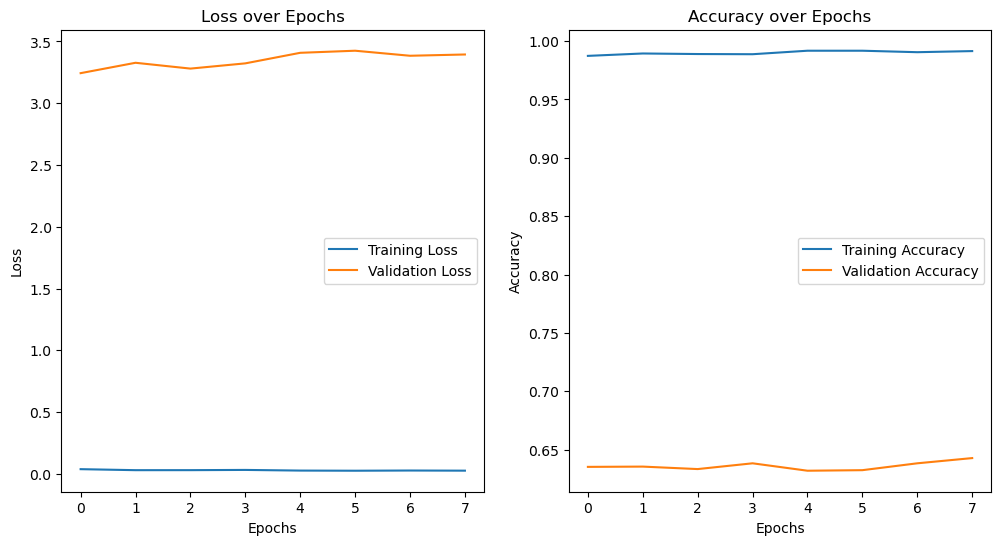

In [797]:
# Plot training & validation loss values
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.epoch, train_loss, label='Training Loss')
plt.plot(history.epoch, val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.epoch, train_acc, label='Training Accuracy')
plt.plot(history.epoch, val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [798]:
test_predictions = model.predict(cleaned_test_features)

133/133 [==============================] - 0s 1ms/step


In [799]:
def ShowPredictionResult(test_predictions, idx=random.randint(0, len(test_predictions)-1)):
    prediction_idx = int(idx)
    prediction = test_predictions[prediction_idx]
    true_img_name = cleaned_test_img_names.iloc[prediction_idx].img_name
    true_label = classes[int(cleaned_test_labels.iloc[prediction_idx].alphabet)]
    img = cv2.imread(train_dir + '/' + true_label + '/' + true_img_name)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title("\nThe image file ('{}') is predicted to be alphabet '{}' with a {:.2f}% confidence.\n The true alphabet label for the image is '{}' "
        .format(true_img_name, classes[np.argmax(prediction)], 100 * np.max(prediction), true_label))
    plt.show()


In [800]:
def ShowBatchPredictionsResult(num_imgs, test_predictions, x_axs, y_axs):
    num_imgs = num_imgs
    x_axs = num_imgs//x_axs
    y_axs = y_axs
    fig, ax = plt.subplots(x_axs+1, y_axs+1) 
    x = 0
    y = 0
    for i in range(num_imgs):
        random_img = random.randint(0, len(test_predictions)-1)
        prediction = test_predictions[random_img]
        true_img_name = cleaned_test_img_names.iloc[random_img].img_name
        true_label = classes[int(cleaned_test_labels.iloc[random_img].alphabet)]
        
        img = cv2.imread(train_dir + '/' + true_label + '/' + true_img_name)
        title = ("\nImg File: ('{}') \nPrediction: '{}' \nConf.: {:.2f}%\nTrue Alphabet: '{}'"
            .format(true_img_name, classes[int(np.argmax(prediction))], 100 * np.max(prediction), true_label))
        ax[x][y].set_title(title)
        ax[x][y].axis('off')
        ax[x][y].imshow(img)

        if y == y_axs:
            y = 0
            x += 1
        else:
            y += 1
    plt.tight_layout()
    plt.show()

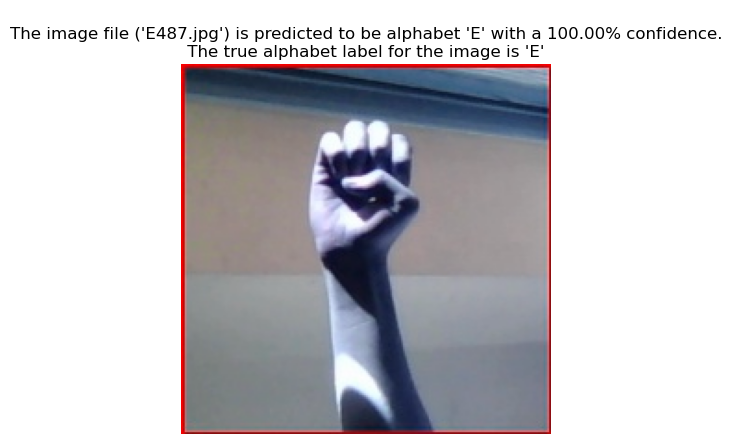

In [801]:
ShowPredictionResult(test_predictions)

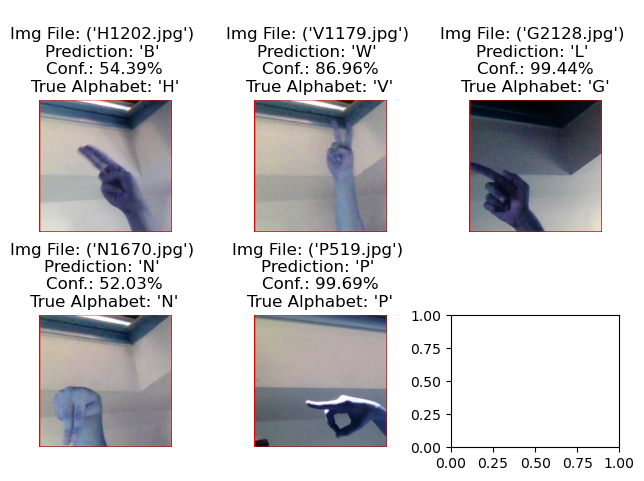

In [786]:
ShowBatchPredictionsResult(5, test_predictions,x_axs=4,y_axs=2)